In [17]:
# -.-|m { input: false, output: false, input_fold: show}

import logging
from os import path, system

import GPUtil
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import session_info
import tomlkit
from anndata import AnnData
from pandas import DataFrame

from utils.util_funcs import cell_typist_annotate

In [18]:
# Add CELL_TYPIST model(s) to use
CELL_TYPIST_MODELS: list[str] = []

In [19]:
# | echo: false
# | output: false
# | warning: false

## Pipeline parameters
with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [20]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])
COUNTS_LAYER = config["normalization"]["COUNTS_LAYER"]
CLUSTERING_COL = config["clustering"]["CLUSTERING_COL"]
TISSUE = config["basic"]["TISSUE"]
ANNOTATION_METHODS = config["annotation"]["ANNOTATION_METHOD"]
NORMAMALIZATION_LAYER = config["normalization"]["NORMALIZATION_METHOD"]

In [21]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

In [27]:
def annotation_dispatcher(method: str, adata: AnnData) -> None:
    if method == "celltypist":
        cell_typist_annotate(adata, CELL_TYPIST_MODELS)
    if method == "scGPT":
        deviceIDs = GPUtil.getAvailable()
        if len(deviceIDs) > 0:
            system(
                f"pixi run -e scgpt scgpt_annotate -i {path.join(DIR_SAVE, 'adata.h5ad')} --config {path.join(ROOT_DIR, 'config.toml')}"
            )
        else:
            print("CUDA is not available, scGPT will not be run efficiently on CPU")
            exit(code=0)

    if method == "scTAB":
        system(
            f"pixi run -e sctab sctab_annotate --input {path.join(DIR_SAVE, 'adata.h5ad')} --config {path.join(ROOT_DIR, 'config.toml')}"
        )
        adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))


# Getting a stable counts layer to be used later, setting X to be raw count values.
if COUNTS_LAYER == "X":
    adata.layers["counts"] = adata.X.copy()
    COUNTS_LAYER = "counts"
elif COUNTS_LAYER in adata.layers.keys():
    adata.X = adata.layers[COUNTS_LAYER].copy()
else:
    raise ValueError("{COUNTS_LAYER} layer can't be found in the object")

if isinstance(ANNOTATION_METHODS, list):
    for METHOD in ANNOTATION_METHODS:
        annotation_dispatcher(METHOD, adata)
elif isinstance(ANNOTATION_METHODS, str):
    annotation_dispatcher(ANNOTATION_METHODS, adata)


✨ Pixi task (sctab_annotate in sctab): python utils/sctab_annotate.py --input /home/mohamed/Documents/Bioinformatics/GPM/analysis/scanpy_pipeline/save/adata.h5ad --config /home/mohamed/Documents/Bioinformatics/GPM/analysis/scanpy_pipeline/config.toml
100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


In [28]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

In [66]:
import logging
import sys
from typing import Optional, Union

from pandas.core.frame import DataFrame

logging.basicConfig(level=logging.INFO, format="%(message)s")
logger = logging.getLogger(__name__)

set_level = logger.setLevel
info = logger.info
warn = logger.warning
error = logger.error
debug = logger.debug


def over_cluster(
    adata, resolution: Optional[float] = None, use_GPU: bool = False
) -> pd.Series:
    """
    Over-clustering input data with a canonical Scanpy pipeline. A neighborhood graph will be used (or constructed if not found) for the over-clustering.

    Parameters
    ----------
    resolution
        Resolution parameter for leiden clustering which controls the coarseness of the clustering.
        Default to 5, 10, 15, 20, 25 and 30 for datasets with cell numbers less than 5k, 20k, 40k, 100k, 200k and above, respectively.
    use_GPU
        Whether to use GPU for over clustering on the basis of `rapids-singlecell`.
        (Default: `False`)

    Returns
    ----------
    :class:`~pandas.Series`
        A :class:`~pandas.Series` object showing the over-clustering result.
    """
    if use_GPU and "rapids_singlecell" not in sys.modules:
        logger.warn(
            "⚠️ Warning: rapids_singlecell is not installed but required for GPU running, will switch back to CPU"
        )
        use_GPU = False
    if "connectivities" not in adata.obsp:
        logger.info(
            "👀 Can not detect a neighborhood graph, will construct one before the over-clustering"
        )
        adata = sc.pp.pca(adata)
        adata = sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

    else:
        logger.info(
            "👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it"
        )
    if resolution is None:
        if adata.n_obs < 5000:
            resolution = 5
        elif adata.n_obs < 20000:
            resolution = 10
        elif adata.n_obs < 40000:
            resolution = 15
        elif adata.n_obs < 100000:
            resolution = 20
        elif adata.n_obs < 200000:
            resolution = 25
        else:
            resolution = 30
    logger.info(f"⛓️ Over-clustering input data with resolution set to {resolution}")
    if use_GPU:
        sc.tl.leiden(adata, resolution=resolution, key_added="over_clustering")
    else:
        sc.tl.leiden(adata, resolution=resolution, key_added="over_clustering")
    return adata.obs.pop("over_clustering")


def majority_vote(
    predictions: pd.DataFrame,
    column: str,
    over_clustering: Union[list, tuple, np.ndarray, pd.Series, pd.Index],
    min_prop: float = 0,
) -> pd.DataFrame:
    if isinstance(over_clustering, (list, tuple)):
        over_clustering = np.array(over_clustering)
    logger.info("🗳️ Majority voting the predictions")
    votes = pd.crosstab(predictions[column], over_clustering)

    majority = votes.idxmax(axis=0).astype(str)
    freqs = (votes / votes.sum(axis=0).values).max(axis=0)
    majority[freqs < min_prop] = "Heterogeneous"
    majority: DataFrame = majority[over_clustering].reset_index()
    majority.index = predictions.index
    majority.columns = ["over_clustering", "majority_voting"]
    majority["majority_voting"] = majority["majority_voting"].astype("category")
    # predictions.predicted_labels = predictions.predicted_labels.join(majority)
    logger.info("✅ Majority voting done!")
    return majority

In [55]:
over_cluster_res = over_cluster(adata, use_GPU=False)
majority_vote_res = majority_vote(adata.obs, "celltype", over_cluster_res, min_prop=0.5)



👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15


🗳️ Majority voting the predictions
✅ Majority voting done!


In [62]:
majority

,over_clustering,majority_voting
AAACCCACACAATGCT-1,38,mast cell
AAACCCAGTTTACTGG-1,199,Heterogeneous
AAACCCATCATGAGGG-1,92,mast cell
AAACCCATCTACACTT-1,208,Heterogeneous
AAACGAAAGAAGTCAT-1,163,fibroblast of cardiac tissue
...,...,...
TTTGTTGGTCATTGCA-1,20,mast cell
TTTGTTGTCCTCTCGA-1,2,endothelial cell
TTTGTTGTCGCACGAC-1,158,platelet
TTTGTTGTCGTCAACA-1,156,Heterogeneous


In [63]:
adata.obs["scTAB_annotation"] = majority["majority_voting"]

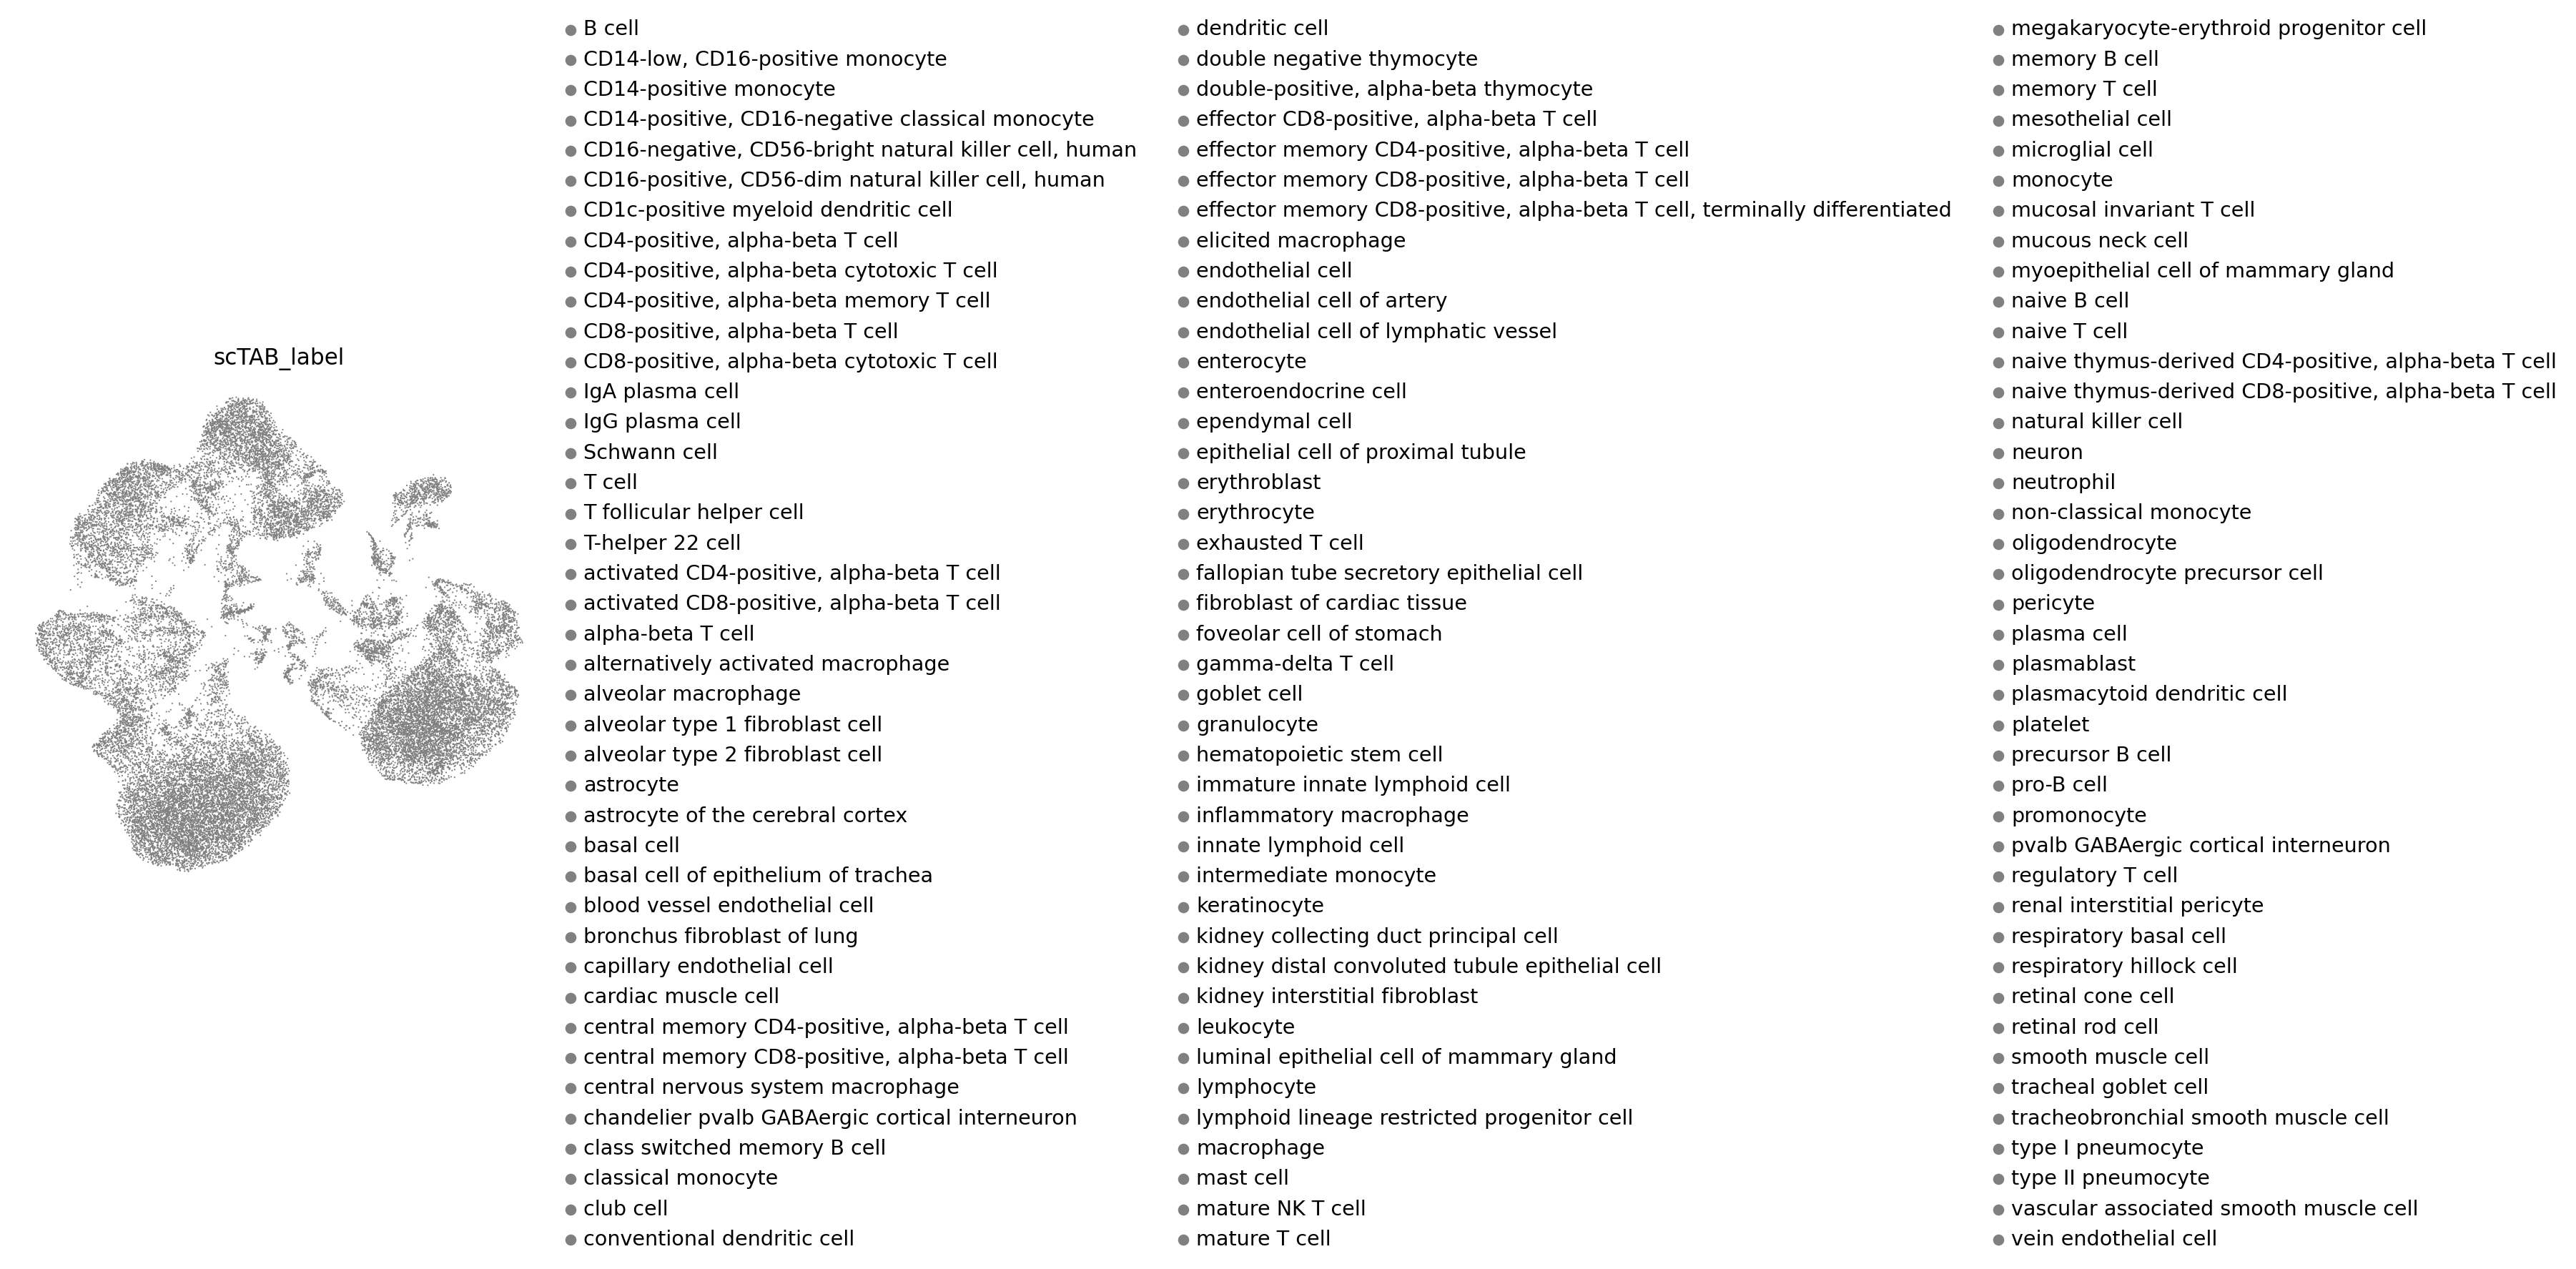

In [65]:
sc.pl.umap(adata, color="scTAB_label")

In [3]:
session_info.show()